In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Camera Calibration

We first proceed to find out the camera's calibration matrix. This will allow us to undistort the raw images. The calibration images of the checkerboard pattern provided in the ./camera_cal folder will be used for this step

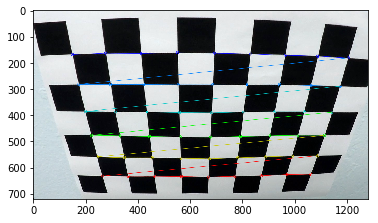

In [2]:
# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# Make a list of calibration images
fname = 'camera_cal/calibration2.jpg'
img = cv2.imread(fname)

#plt.imshow(img)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [3]:
import glob

images = glob.glob("camera_cal/*.jpg")

#Camera calibration process for all images

imgpoints = []
objpoints = []

#prepare object coordinates (0,0,0) (1, 0, 0) , ... (9, 6, 0)
objp = np.zeros( (nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) #x, y cols

#For image and object points list
for fname in images:
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

print(len(imgpoints))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

np.savez('calibration_data', [mtx, dist])

17


### Load camera calibration and proceed to check it

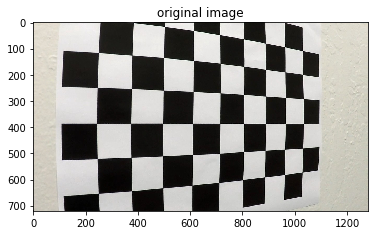

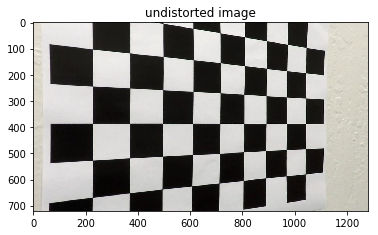

In [4]:
cals = np.load('calibration_data.npz')
mtx, dist = cals['arr_0'][0] , cals['arr_0'][1]


#Get random image and undistort it

fname = "camera_cal/calibration5.jpg"
img = mpimg.imread(fname)
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure()
plt.imshow(img)
plt.title("original image")
plt.figure()
plt.imshow(dst)
plt.title("undistorted image")

### Now we use the checkerboard image to generate the perspective transform
The perspective transform allows us to view the image from the birds-eye-view plot which will make it easier to identify the lanes


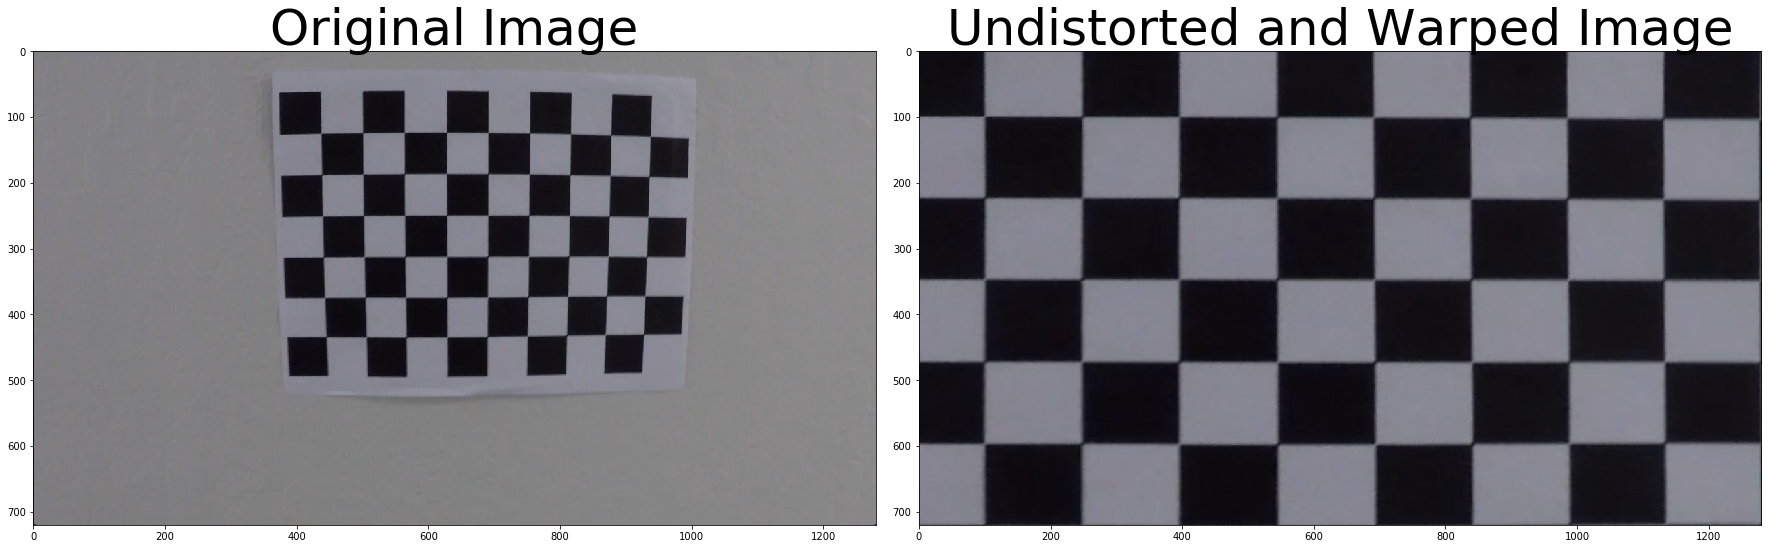

In [168]:
import pickle

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    
    #1) undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    offset = 100
    width = gray.shape[1] - offset
    height = gray.shape[0] - offset
    if ret:
        img2 = cv2.drawChessboardCorners(gray, (nx,ny), corners, ret)
        src1 = corners[0]
        src2 = corners[nx-1]
        src3 = corners[-1]
        src4 = corners[-nx]
        src = np.stack([src1[0], src2[0], src3[0], src4[0]])
        dst = np.float32([ [offset, offset], [offset+width, offset], [offset+width, offset+height], 
                [offset, offset+height]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(undist, M, (width + offset, height+offset))
    return warped, M, Minv

img = mpimg.imread("camera_cal/calibration18.jpg")
top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save all cals in a pickle file
dict_pickle = { "mtx" : mtx, "dist" : dist}
pickle.dump(dict_pickle, open("saved_cals.p", 'wb'))


## Finding Lane pixels with color transform and gradient thresholding

In order to detect lane pixels we need to transform the images to a suitable colorspace and then apply thresholding. In addition we are focused on pixels that have a high enough x gradient. So we combine these two processes to come up with a final thresholded binary image

In [5]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    binary_output = np.zeros_like(s)
    binary_output[ (s >= thresh[0]) & (s <= thresh[1]) ] = 1
    return binary_output

def hsv_select(img, thresh=(0,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]
    binary_output = np.zeros_like(v)
    binary_output[ (v >= thresh[0]) & (v <= thresh[1]) ] = 1
    return binary_output

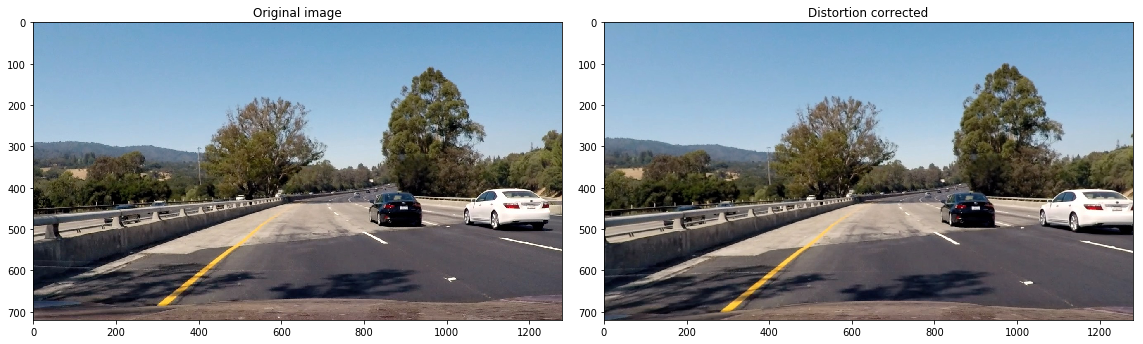

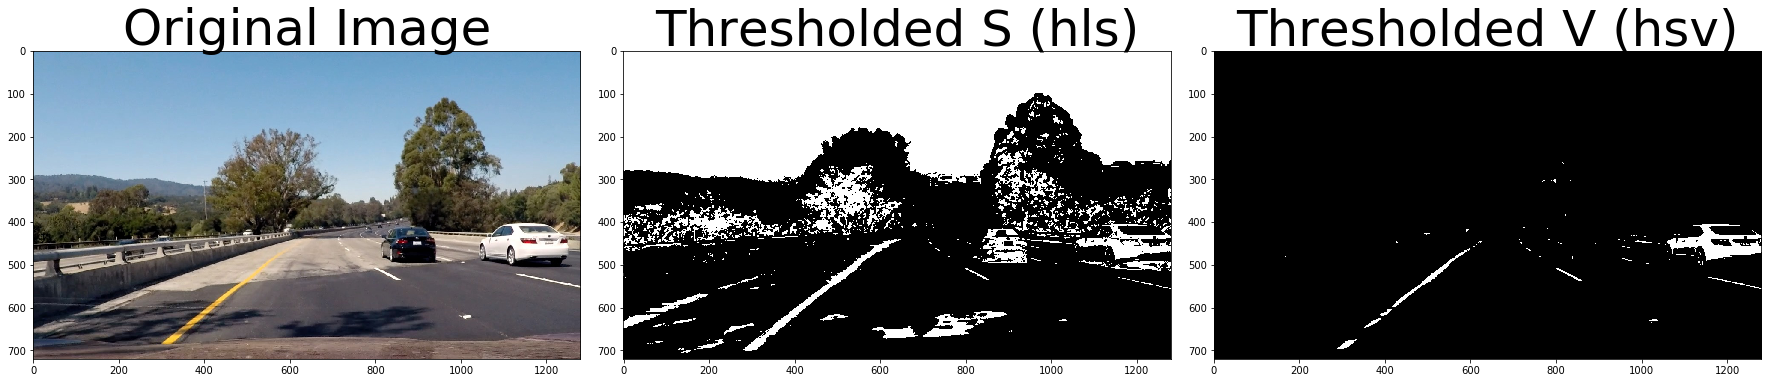

In [10]:
import pickle

imgfile = "test_images/test4.jpg"
dict_pickle = pickle.load(open("saved_cals.p",'rb'))
mtx = dict_pickle["mtx"]
dist = dict_pickle["dist"]

image = mpimg.imread(imgfile)

warped_image = cv2.undistort(image, mtx, dist, mtx)
hls_binary = hls_select(warped_image, thresh=(90, 255))
hsv_binary = hsv_select(warped_image, thresh=(230, 255))

f1, (ax11, ax12) = plt.subplots(1, 2, figsize = (16,9))
f1.tight_layout()
ax11.imshow(image)
ax11.set_title('Original image')
ax12.imshow(warped_image)
ax12.set_title('Distortion corrected')

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S (hls)', fontsize=50)
ax3.imshow(hsv_binary, cmap = 'gray')
ax3.set_title('Thresholded V (hsv)', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient thresholding to detect near vertical edges using sobel edge detection

In [13]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray, orient='x', sobel_kernel = 7, thresh = (0, 255)):
    sobelout = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize = sobel_kernel)
    abssobelout = np.abs(sobelout)
    scaled8bitsobel = np.uint8(255 * abssobelout/np.max(abssobelout))
    binary_output = np.zeros_like(sobelout)
    binary_output[ (scaled8bitsobel >= thresh[0]) & (scaled8bitsobel <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1, ksize = sobel_kernel)
    abs_sobelxy = np.sqrt( sobelx**2 + sobely**2)
    abs_sobelxyscaled = np.uint8( 255 * abs_sobelxy / np.max(abs_sobelxy))
    binary_output = np.zeros_like(abs_sobelxyscaled)
    binary_output[ (abs_sobelxyscaled >= mag_thresh[0]) & (abs_sobelxyscaled <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    abs_sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize= sobel_kernel))
    abs_sobely = np.abs(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize= sobel_kernel))
    theta = np.abs(np.arctan2(abs_sobely, abs_sobelx))
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[ (theta >= thresh[0]) & (theta <= thresh[1]) ] = 1
    return binary_output

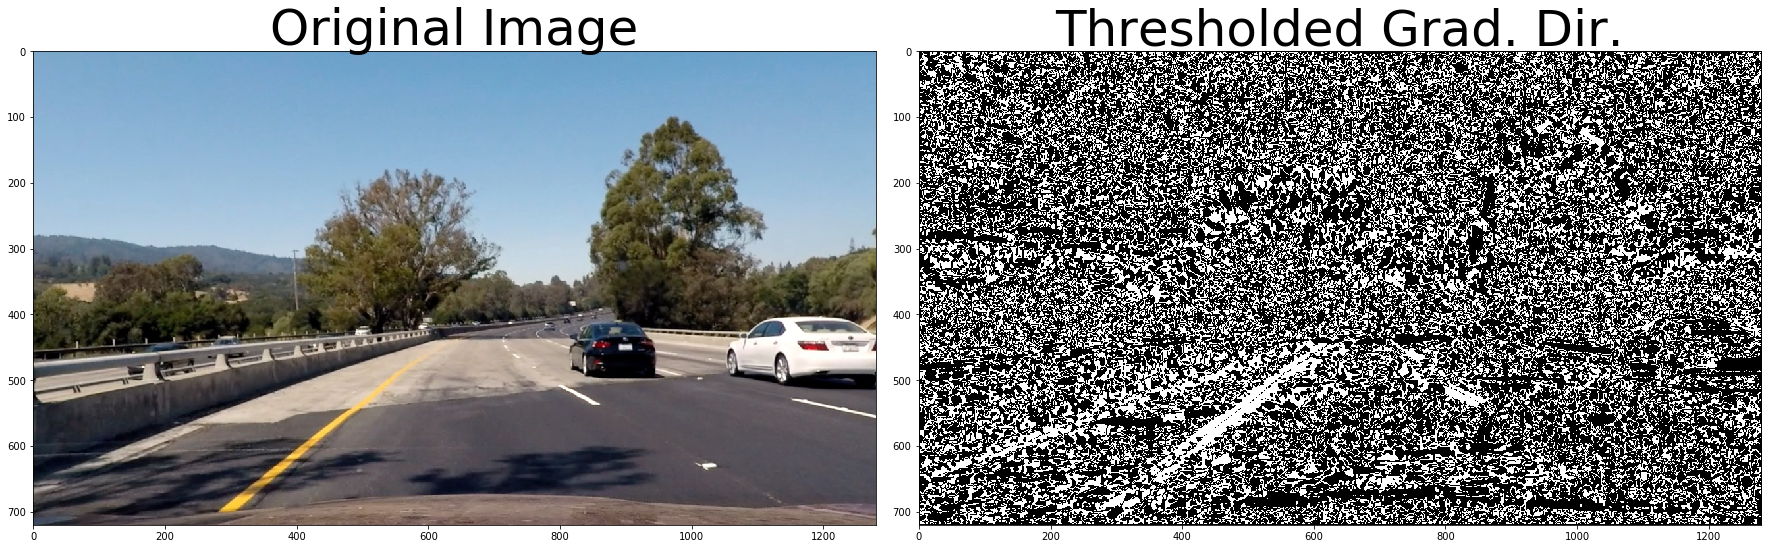

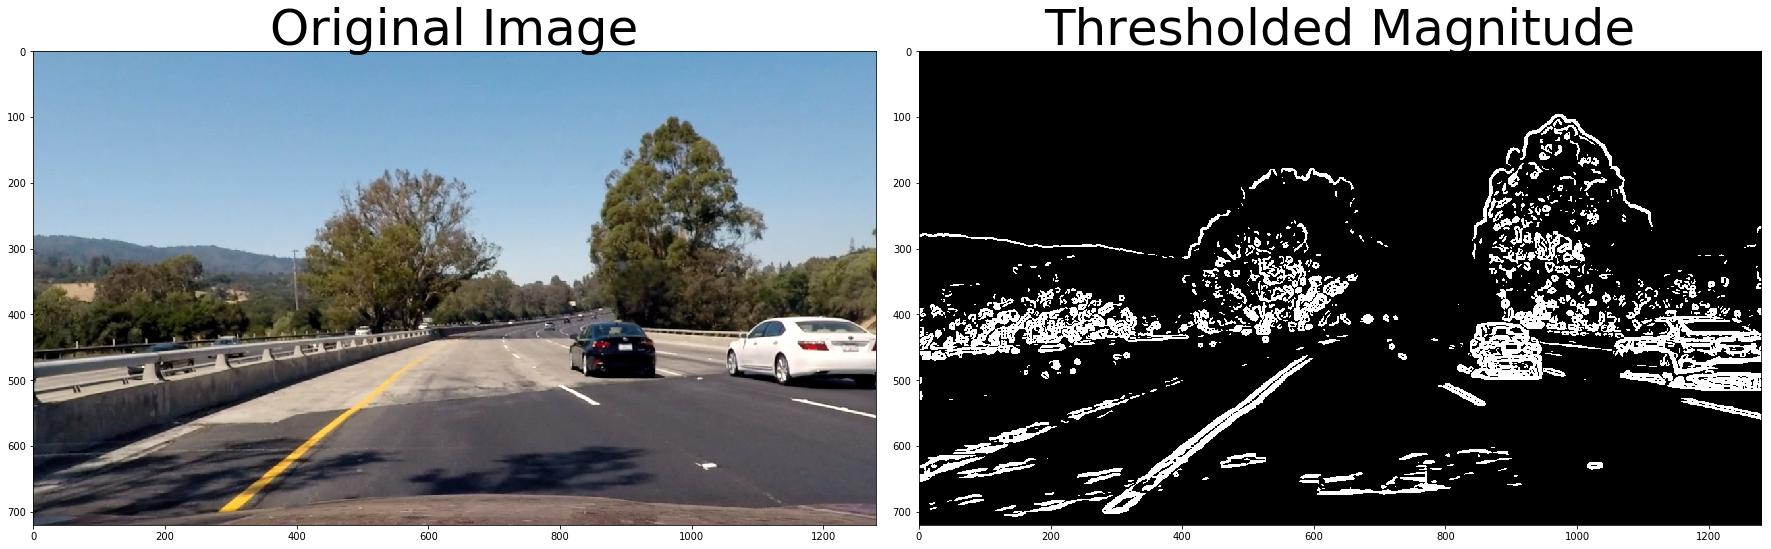

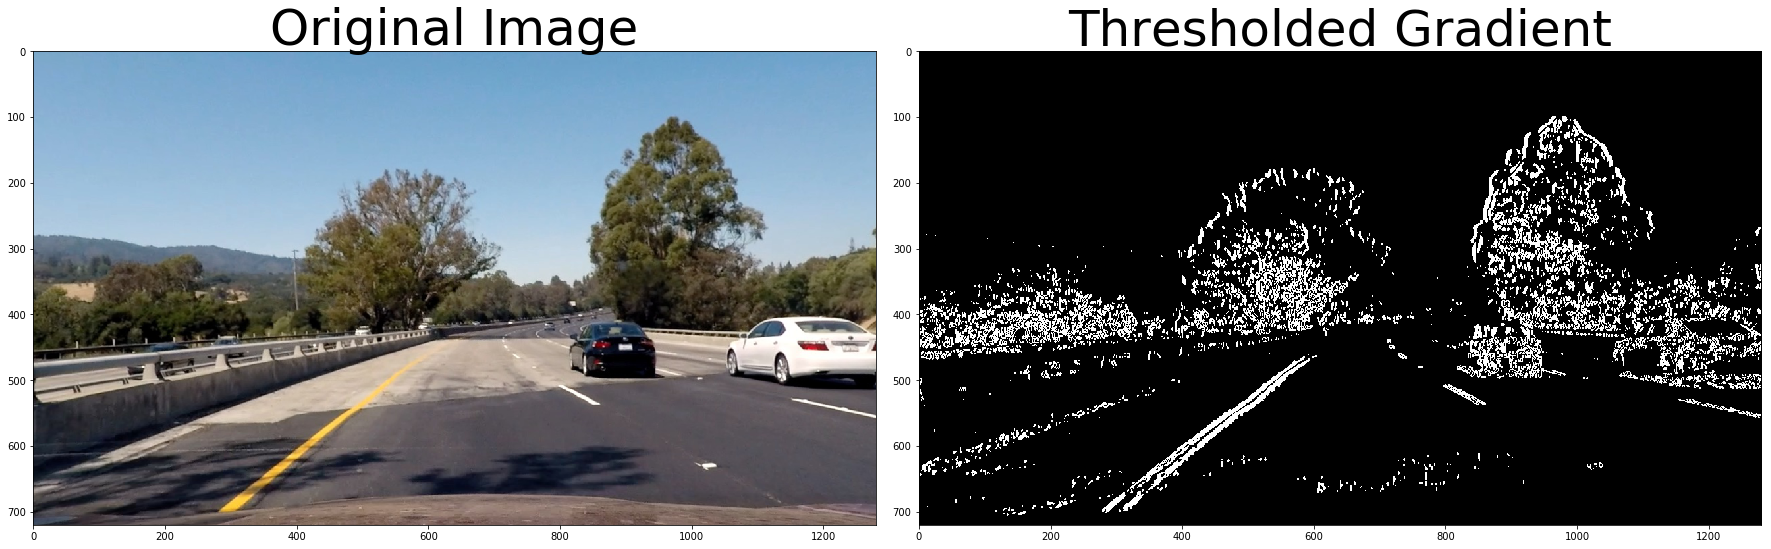

In [14]:
imgfile = "test_images/test4.jpg"

image = mpimg.imread(imgfile)
image = cv2.undistort(image, mtx, dist, mtx)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray = hls[:, :, 2]
# Run the function
dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Run the function
mag_binary = mag_thresh(gray, sobel_kernel=15, mag_thresh=(40, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Run the function
grad_binary = abs_sobel_thresh(gray, orient='x', thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

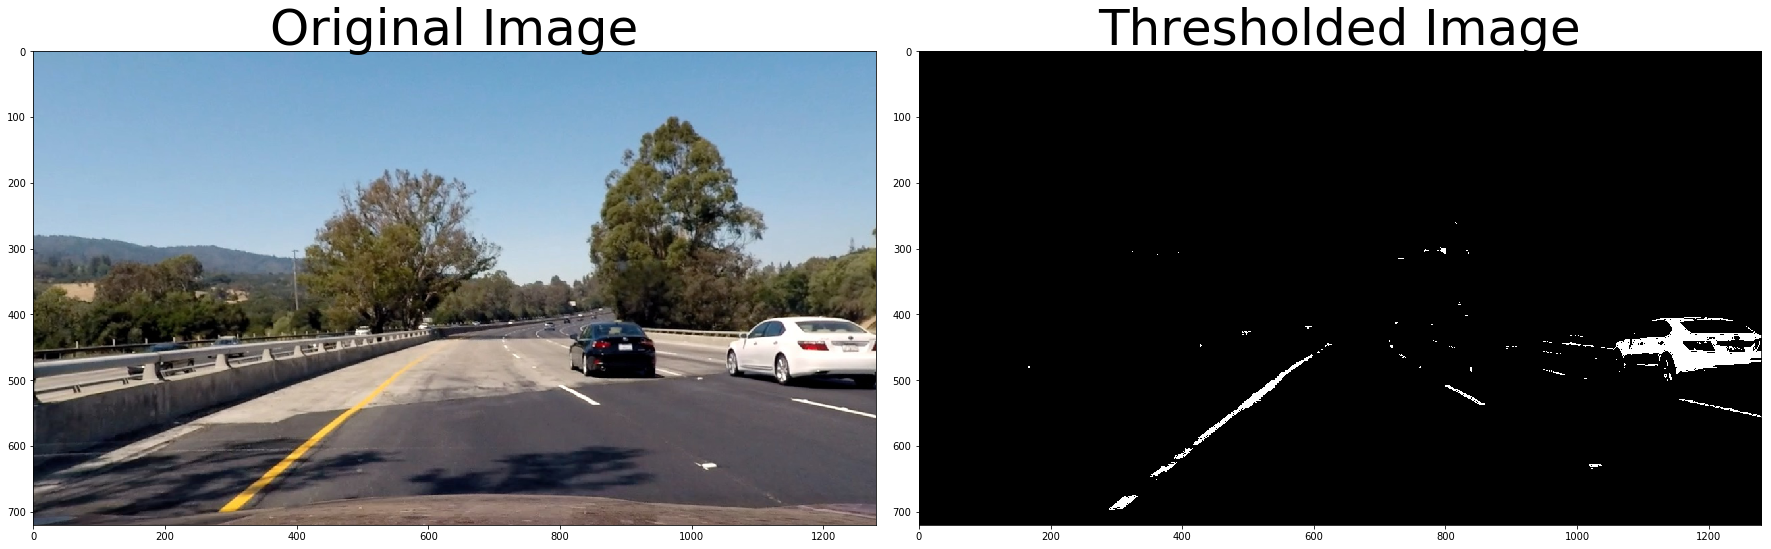

In [15]:
#Combine images
# Apply each of the thresholding functions

imgfile = "test_images/test4.jpg"

image = mpimg.imread(imgfile)
image = cv2.undistort(image, mtx, dist, mtx)
hls_binary = hls_select(image, thresh=(90, 255))
hsv_binary = hsv_select(image, thresh=(230, 255))
gray = cv2.cvtColor(warped_image, cv2.COLOR_RGB2GRAY)
ksize = 7
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 255))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[ ((gradx == 1 & (grady == 1)) | (mag_binary == 1)) & ((hsv_binary == 1)) ] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply perspective transform to image


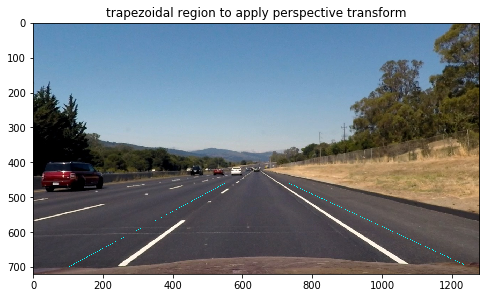

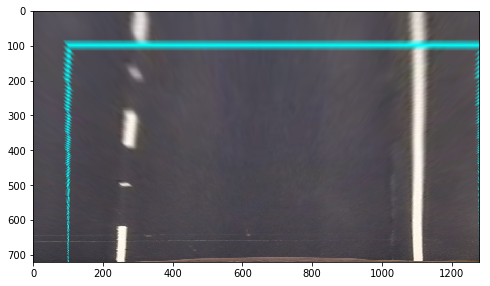

In [20]:
#plot this trapezoid on the image
bot_left = [100, 700]
top_left = [550, 460]
top_right = [732, 460]
bot_right = [1250, 700]

imgfile = "test_images/straight_lines2.jpg"

image = mpimg.imread(imgfile)
undist = cv2.undistort(image, mtx, dist, mtx)

pts = np.array([bot_left, top_left, top_right, bot_right], np.int32)
polypts = pts.reshape((-1,1,2))
image = cv2.polylines(undist,[polypts],True,(0,255,255))

plt.figure(figsize= (8,5))
plt.imshow(image)
plt.title('trapezoidal region to apply perspective transform')

offset = 100
width = image.shape[1] - offset
height = image.shape[0] - offset
src = np.stack([top_left, top_right, bot_right, bot_left]).astype(np.float32)
dst = np.float32([ [offset, offset], [offset+width, offset], [offset+width, offset+height], 
                [offset, offset+height]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undist, M, (width + offset, height+offset))
plt.figure(figsize = (8,5))
plt.imshow(warped)

dict_pickle["pM"] = M
dict_pickle["pMinv"] = Minv
pickle.dump(dict_pickle, open("saved_cals.p", "wb"))

## Pipeline setup
preprocess_image function will 

1. undistort the image
2. compute the binary image thresholded for lane markers
3. warp the image using perspective transform
4. find lane pixels in the image 
5. build the lane model
6. transform the coordinates back to the original image


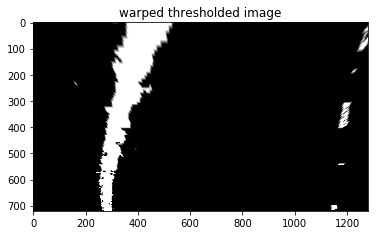

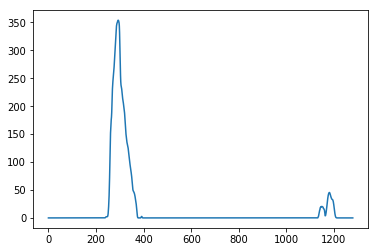

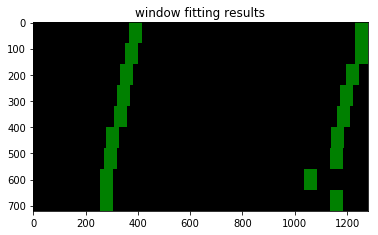

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
imgfile = "test_images/test1.jpg"

image = mpimg.imread(imgfile)
undist = cv2.undistort(image, mtx, dist, mtx)

#Threshold iamge
hls_binary = hls_select(undist, thresh=(90, 255))
#hsv_binary = hsv_select(undist, thresh=(230, 255))
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
ksize = 7
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 255))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[ ((gradx == 1 & (grady == 1)) | (mag_binary == 1)) & ((hls_binary == 1)) ] = 1

warped = cv2.warpPerspective(combined, M, (width + offset, height+offset))

plt.figure()
plt.imshow(warped, cmap = 'gray')
plt.title('warped thresholded image')

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.figure()
plt.plot(histogram)

# window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 0.5, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure()
plt.imshow(output)
plt.title('window fitting results')
plt.show()


(720, 0)

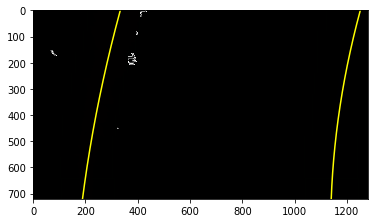

In [114]:
binary_warped = warped

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = binary_warped.shape[0]//nwindows
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


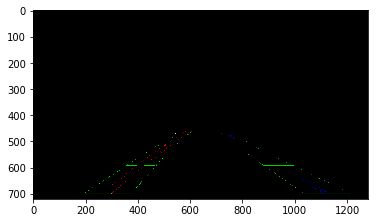

In [115]:
#re project points back to image

unwarped = cv2.warpPerspective(out_img, Minv, (width + offset, height+offset))
plt.figure()
plt.imshow(unwarped)

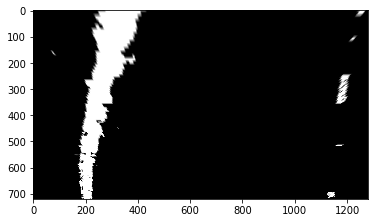

In [116]:
plt.figure()
plt.imshow(binary_warped, cmap = 'gray')

(50, 3)


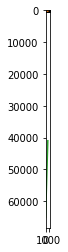

In [157]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
x = nonzerox.reshape(-1,1)
y = nonzeroy.reshape(-1,1)

poly_2 = PolynomialFeatures(degree=2)
x_2 = poly_2.fit_transform(x)
model_ransac.fit(y, x_2)
ypred = model_ransac.predict(np.linspace(0, 700).reshape(-1,1))
print(ypred.shape)
fig, ax = plt.subplots()
ax.imshow(binary_warped, cmap = 'gray')
ax.plot(np.linspace(0, 700), ypred)